# Project 1: Interpolation with Autoregressive (AR) Model
# Solution
## Deniz Ekiz, 2016700051

- Read the flights.csv file into two column vectors T and X, where X is partially observed
monthly totals of international airline passengers and T is the corresponding months.
Plot T vs. X.

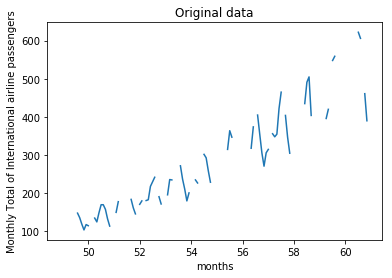

[False  True  True False  True False  True False False False False False
 False  True  True False False False False False False False False  True
  True False False  True False  True False  True False False False  True
 False False  True False False False False False  True False False  True
  True False False False  True False  True False False False False False
  True  True False False  True  True False False False False  True  True
 False  True  True False  True False False False  True  True False  True
  True  True False  True False False  True False False False False False
 False  True False False False False False  True False False False  True
  True False  True False  True False False False False  True False  True
  True False  True False False  True False False  True False  True  True
 False  True  True  True  True  True False False  True False False  True]


In [369]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

my_data = np.genfromtxt('flights.csv', delimiter=',')
my_data = my_data[1:,]
T = my_data[:,0]
X = my_data[:,1]
#print X
plt.plot(T -1900,X)
plt.xlabel('months')
plt.ylabel('Monthly Total of International airline passengers')
plt.title('Original data')
plt.show()
X_mi_sel = np.isnan(X)
#X = np.nan_to_num(X)
#print X_mi
#np.where(np.invert(X_mi_sel))
#for i in range(0,len(X_mi_sel)):
#    if X_mi_sel[i]:
#        X[i] = 999

- Iteratively construct $G_X$ and solve for A 
- then fix A construct $G_A$ and solve for $X^{mi}$ by least
squares (Alternating Least Squares). 

$G_A(X^{obs} + X^{mi}) = \epsilon$

$G_AX^{mi}=\epsilon -  G_AX^{obs}  $


You can choose M = 4.

Fix X

Compute

$A =  (G_X^TG_X)^{-1}(G_X^TG_X)$.

Fix A

Solve

$X^{mi} = -1(G_A^TG_A)^{-1}(G_A^TG_AX^{ob})$.

Update

$X = X^{mi}$

Select M = 4



In [434]:
#Creates Gx
M = 4
T = my_data[:,0]
X = my_data[:,1]
#creates Xmi
def Xmi(X):
    T = np.copy(X)
    for i in range(0,len(X_mi_sel)):
        if not X_mi_sel[i]:
            T[i] = 0
    return T
#creates Xobs
def Xobs(X):
    T = np.copy(X)
    for i in range(0,len(X_mi_sel)):
        if X_mi_sel[i]:
            T[i] = 0
    return T

def G_x(X_a,shape):
    Gxx = np.zeros((shape-M,M))
    for i in range(M,shape):
        for m in range(0,M):
            Gxx[i-M,m] = np.copy(X_a[i-(m+1)])
    return Gxx;

#Creates Ga, from X and shape
def G_a(X_b,shape):
    Gaa = np.zeros((shape,shape+M))
    #Gaa.shape = (shape,shape+4)
    for i in range(0,shape):
        for m in range(0,M):
            Gaa[i,m+i] = np.copy(X_b[m])
        Gaa[i,M+i] = -1
    return Gaa;
def norm_lsq(A,b):
    A_t_A = np.dot(A.conj().transpose(),A)
    A_t_b = np.dot(A.conj().transpose(),b)
    return np.linalg.solve(A_t_A,A_t_b)
def svd_lsq(A,b):
    U, E, V_T = np.linalg.svd(A, full_matrices=False)
    V = V_T.conj().transpose()
    e = np.diag(E)
    u_T_b = np.dot(U.conj().transpose(),b)
    m = np.linalg.solve(e,u_T_b)
    sol = np.dot(V,m)
    return sol
#Deletes the nan values
def nan_to_mean(X,j):
    T = np.copy(X)
    mean = np.mean(X[~np.isnan(X)])
    for i in range(j,len(X_mi_sel)):
            #if X_mi_sel[i]:
        if np.isnan(T[i]):
            T[i] = np.copy(T[i-1])
    #print "T\n",T
    return T
X_mi = np.zeros(144)
X_obs_i = np.copy(np.nan_to_num(X))
OO = np.copy(nan_to_mean(X,0))
for i in range(0,100):
    Gx = G_x(X,144)
    LL = np.copy(np.nan_to_num(X))
    sample = G_x(LL,144)
    A_i = svd_lsq(sample,LL[M:])
    Ga = G_a(A_i,144-M)
    #print A_i
    F = np.copy(X_obs_i)
    w = np.dot(-1,np.dot(Ga,F))
    X_mi = Xmi(X)
    #print X_mi
    X_mi_n = np.array([])
    X_obs_n = np.array([])
    Ga_n = np.array([])
    Ga_obs_n = np.array([])
    for i in range(0,len(X_mi)):
        if X_mi[i] != 0:
            X_mi_n = np.concatenate((X_mi_n,[X_mi[i]]))
            if len(Ga_n)>0:
                Ga_n = np.column_stack((Ga_n,Ga[:,i]))
            else:
                Ga_n = Ga[:,i]
        else:
            X_obs_n = np.concatenate((X_obs_n,[X_obs_i[i]]))
            if len(Ga_obs_n)>0:
                Ga_obs_n = np.column_stack((Ga_obs_n,Ga[:,i]))
            else:
                Ga_obs_n = Ga[:,i]
    F = np.copy(X_obs_n)
    w = np.dot(-1,np.dot(Ga_obs_n,F))
    #print Ga_n
    #print X_mi_n
    #print X_mi_n
    #print X_obs_i
    X_mi_n = svd_lsq(Ga_n,w)
    #X_mi_n = np.linalg.lstsq(a= Ga_n,b=w)[0]
    #print X_mi
    #print len(X_mi)
    z = 0
    for i in range(0,len(X_mi)):
        if X_mi[i] != 0:
            X_mi[i] = X_mi_n[z]
            z = z+1
    #X_mi = np.linalg.lstsq(a= Ga,b=w)[0]
    #X = X_mi
    X = np.sum([Xmi(X_mi),Xobs(X)],axis=0)
#print X
#print LL
#print "X_obs",X_obs_i
#print "X", X

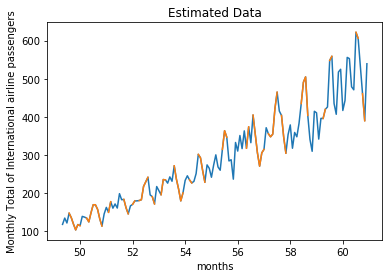

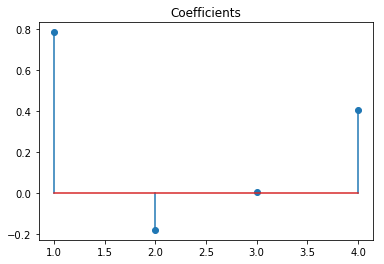

In [436]:
%matplotlib inline
z = 0
#print LL
#print X_mi
#plt.plot(T[M:] -1900,np.sum([X_mi[M:],X_obs_i[M:]],axis=0))
plt.plot(T[M:] -1900,X[M:])
#plt.plot(T[M:] -1900,OO[M:])
#plt.plot(T[M:] -1900,FF)
plt.plot(T[M:] -1900,my_data[M:,1])
plt.xlabel('months')
plt.ylabel('Monthly Total of International airline passengers')
plt.title('Estimated Data')
plt.show()
fig, ax = plt.subplots()
ax.stem(range(1,M+1),A_i)
plt.title('Coefficients')
plt.show()
#print np.dot(Ga.T,Ga)
#RR = np.dot(Ga.T,Ga)
#print np.linalg.inv(RR)
#print X_mi_sel
#print X_mi.T + X_obs.T
#print  X_mi
#print X_obs_i
#print np.sum([X_mi,X_obs_i],axis=0)


# Project 1 Bonus

Assume X is fully observed, then we can write following system of linear equations:
$
\begin{bmatrix}
    X_{M} \\
    X_{M+1}   \\
    \vdots  \\
    X_{N}  
\end{bmatrix}
=
\begin{bmatrix}
    X_{M-1} & X_{m-2} &\dots & X_{0}  & T_{M} & 1\\
    X_{M} & X_{M-1} & \dots   & X_{1} & T_{M+1} & 1\\
    \vdots & \vdots & \ddots  & \vdots & \vdots & \vdots\\
    X_{N-1} & X_{N-2} & \dots   & X_{N-M} & T_{N} & 1
\end{bmatrix}
\begin{bmatrix}
    A_{1} \\
    A_{2}   \\
    \vdots  \\
    A_{M}  \\
    C \\
    D
\end{bmatrix}
+
\begin{bmatrix}
    \epsilon_{M} \\
    \epsilon_{M+1}   \\
    \vdots  \\
    \vdots  \\
    \vdots \\
    \epsilon_{N}
\end{bmatrix}$

which we will be denoted by $X_{M:N} = G_XA + \epsilon$. Similarly, if we assume A is known, hopefully we know all of the T's.

$\begin{bmatrix}
    \epsilon_{M} \\
    \epsilon_{M+1}   \\
    \vdots  \\
    \vdots  \\
    \epsilon_{N-1}\\
    \epsilon_{N}
\end{bmatrix}
=
\begin{bmatrix}
    A^{T} & -1 & 0 & 0 & \dots  &  0\\
    0 & A^{T} & -1   & 0 &\dots  & 0\\
    \vdots & \ddots & \ddots  & \ddots & -1 & 0 \\
    0 & \dots & 0   & 0 & A^{T} & -1
\end{bmatrix}
\begin{bmatrix}
    X_{0} \\
    X_{1}   \\
    \vdots  \\
    X_{N-1} \\
    X_N
\end{bmatrix}
+
\begin{bmatrix}
    T_{M} & 1\\
    T_{M+1}& 1 \\
    \vdots \\
    T_{N} & 1
\end{bmatrix}
$
$
\begin{bmatrix}
    C\\
    D
\end{bmatrix}
$

If we solve the equation above we will have a better estimate

In [439]:
X = my_data[:,1]
T = my_data[:,0]
X_mi = np.zeros(144)
X_obs_i = np.copy(np.nan_to_num(X))
for i in range(0,500):
    if i == 0:
        LL = np.copy(np.nan_to_num(X))
    else:
        LL = X
    Gx = G_x(LL,144)
    Gx = np.column_stack((Gx,T[M:].T))
    Gx = np.column_stack((Gx,np.ones(144-M).T))
    A_i = svd_lsq(Gx,LL[M:])
    Ga = G_a(A_i[:M],144-M)
    
    
    #print A_i
    F = np.copy(Xobs(X))
    w = np.dot(-1,np.dot(Ga,F))
    X_mi = Xmi(X)
    #print X_mi
    X_mi_n = np.array([])
    Ga_n = np.array([])
    for i in range(0,len(X_mi)):
        if X_mi[i] != 0:
            X_mi_n = np.concatenate((X_mi_n,[X_mi[i]]))
            if len(Ga_n)>0:
                Ga_n = np.column_stack((Ga_n,Ga[:,i]))
            else:
                Ga_n = Ga[:,i]
    #print Ga_n
    #print X_mi_n
    X_mi_n = np.copy(np.nan_to_num(X_mi_n))
    #print A_i
    X_mi_n = svd_lsq(Ga_n,np.sum([w,np.dot(-Gx[:,-2:],A_i[-2:].T)],axis=0 ))
    #print len(X_mi_n)
    #X = X_mi
    z = 0
    for i in range(0,len(X_mi)):
        if X_mi[i] != 0:
            X_mi[i] = X_mi_n[z]
            z = z+1
    X = np.sum([Xmi(X_mi),Xobs(X)],axis=0)
#print X
#print LL
#print "X_obs",X_obs_i
#print "X", X

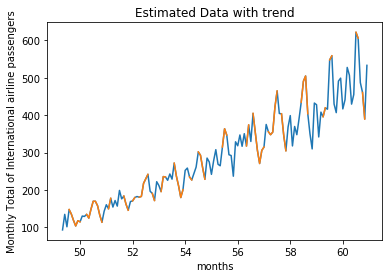

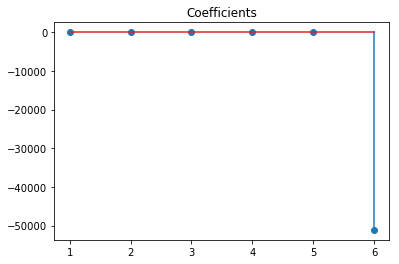

In [441]:
%matplotlib inline
z = 0
#print LL
#print X_mi
#plt.plot(T[M:] -1900,np.sum([X_mi[M:],X_obs_i[M:]],axis=0))
plt.plot(T[M:] -1900,X[M:])
#plt.plot(T[M:] -1900,OO[M:])
#plt.plot(T[M:] -1900,FF)
plt.plot(T[M:] -1900,my_data[M:,1])
plt.xlabel('months')
plt.ylabel('Monthly Total of International airline passengers')
plt.title('Estimated Data with trend')
plt.show()
fig, ax = plt.subplots()
ax.stem(range(1,M+3),A_i)
# coefficients are A_{1:M}, C,D
plt.title('Coefficients')
plt.show()

# Project 2 Image Segmentation with Spectral Clustering

- Read the stones rgb.jpg into a tensor $X ∈ R^{64×64×3}$ where the color intensity of channel
c (red, green, or blue) at pixel $(x, y)$ is denoted by $X_{xyc}$ (see: imread). Then, plot the
image (see: imshow).